In [1]:
import os
import gc
import parse
import logging
import numpy as np
import pandas as pd

from utils import get_N_tokens, read_and_split_file, raw_dir, interim_dir, final_dir, load_SET_dataset

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)

# Generating train dataset and splitting it in train and test

In [2]:
texts, labels = list(), list()

files = ["bswac_tail_pp", "cnrwac_tail_pp_corrected", "hrwac_tail_pp", "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang] * len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})


from sklearn.model_selection import train_test_split

train, eval_df = train_test_split(train, test_size=0.1, stratify=train.labels)


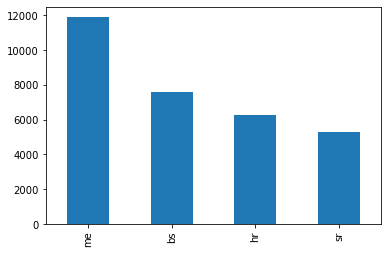

In [12]:
import matplotlib.pyplot as plt


eval_df.labels.value_counts().plot(kind="bar")

plt.show()

In [28]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()


def get_stats(N: int, train=train, eval_df=eval_df, clf=clf):
    import gc
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics import (
        f1_score,
        ConfusionMatrixDisplay,
        confusion_matrix,
        accuracy_score,
    )

    gc.collect()
    vocabulary = get_N_tokens(N)

    def get_coverage(s:str) -> int:
        """Calculates how many vocabulary tokens are in the string.

        Args:
            s (str): input string

        Returns:
            int: number of DISTINCT vocabulary tokens in input string.
        """        
        word_set = set(s.split(" "))
        return len(word_set.intersection(vocabulary))
    vectorizer = CountVectorizer(vocabulary=vocabulary, lowercase=True, binary=True)
    
    eval_df["coverage"] = eval_df.text.apply(get_coverage)
    average_coverage = eval_df.coverage.mean()


    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels
    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels


    clf.fit(train_vectors.toarray(), train_labels)
    y_pred = clf.predict(test_vectors.toarray())

    LABELS = ["hr", "bs", "sr", "me"]

    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS, average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    bool_coverage = eval_df.coverage.value_counts()[0]
    return {"N": N, "microF1": micro, "macroF1": macro, "accuracy": acc, "cm": cm,
    "coverage": average_coverage, "clf": clf.__str__(), "bool_coverage": bool_coverage}


In [29]:
Ns = np.logspace(1, 4, 30, dtype=np.int)
results = list()
for N in Ns:
    try:
        logging.info(f"{N=}")
        rezdict = get_stats(N, train=train, eval_df=eval_df, clf=clf)
        rezdict["eval_df"] = "web crawl 10%"
        results.append(rezdict)
    except MemoryError:
        break

2022-01-13 17:25:15,757 - N=10
2022-01-13 17:26:04,574 - N=12
2022-01-13 17:26:52,201 - N=16
2022-01-13 17:27:40,356 - N=20
2022-01-13 17:28:28,527 - N=25
2022-01-13 17:29:17,200 - N=32
2022-01-13 17:30:05,494 - N=41
2022-01-13 17:30:54,900 - N=52
2022-01-13 17:31:44,989 - N=67
2022-01-13 17:32:36,048 - N=85
2022-01-13 17:33:27,842 - N=108
2022-01-13 17:34:19,530 - N=137
2022-01-13 17:35:13,764 - N=174
2022-01-13 17:36:09,571 - N=221
2022-01-13 17:37:06,737 - N=280
2022-01-13 17:38:06,569 - N=356
2022-01-13 17:39:09,528 - N=452
2022-01-13 17:40:15,162 - N=573
2022-01-13 17:41:25,597 - N=727
2022-01-13 17:42:41,031 - N=923
2022-01-13 17:44:03,110 - N=1172
2022-01-13 17:45:33,576 - N=1487
2022-01-13 17:47:12,293 - N=1887
2022-01-13 17:48:59,849 - N=2395
2022-01-13 17:50:59,078 - N=3039
2022-01-13 17:53:12,845 - N=3856
2022-01-13 17:55:45,584 - N=4893
2022-01-13 17:58:41,583 - N=6210
2022-01-13 18:02:06,975 - N=7880
2022-01-13 18:06:28,885 - N=10000


In [30]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.to_csv("20_results_NB_on_10_percent_of_web_data_extended.csv")
rezdf

,microF1,macroF1,accuracy,cm,coverage,clf,bool_coverage,eval_df
N,,,,,,,,
10,0.394090,0.345192,0.394090,"[[6151, 31, 26, 35], [6511, 358, 537, 158], [3...",0.655300,GaussianNB(),19742,web crawl 10%
12,0.414833,0.370788,0.414833,"[[6129, 33, 49, 32], [6331, 392, 678, 163], [2...",0.789890,GaussianNB(),18280,web crawl 10%
16,0.447319,0.403153,0.447319,"[[6116, 33, 59, 35], [5919, 458, 943, 244], [2...",1.097490,GaussianNB(),15490,web crawl 10%
20,0.479902,0.437654,0.479902,"[[6094, 42, 67, 40], [5683, 588, 1027, 266], [...",1.378476,GaussianNB(),13608,web crawl 10%
25,0.499129,0.455576,0.499129,"[[6100, 38, 63, 42], [5539, 621, 1063, 341], [...",1.660333,GaussianNB(),12274,web crawl 10%
32,0.518485,0.474315,0.518485,"[[6096, 39, 66, 42], [5330, 691, 1128, 415], [...",1.974934,GaussianNB(),10971,web crawl 10%
41,0.534002,0.493636,0.534002,"[[6089, 47, 78, 29], [5110, 854, 1224, 376], [...",2.431899,GaussianNB(),9403,web crawl 10%
52,0.548132,0.504382,0.548132,"[[6097, 46, 70, 30], [5008, 840, 1205, 511], [...",2.846603,GaussianNB(),8293,web crawl 10%
67,0.564520,0.523552,0.564520,"[[6086, 49, 81, 27], [4755, 1023, 1217, 569], ...",3.393671,GaussianNB(),7057,web crawl 10%


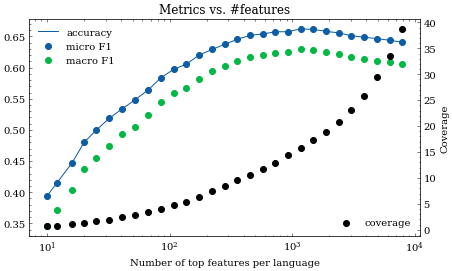

In [31]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.xlabel("Number of top features per language")

ax = plt.gca()
ax2 = plt.twinx()

ax2.scatter(rezdf.index, rezdf["coverage"], label="coverage", c="k")
ax2.set_ylabel("Coverage")
ax2.legend(loc="lower right")

plt.title("Metrics vs. #features")
plt.semilogx()
plt.savefig("images/20_in_domain_coverage_NB.png")
plt.show()

In [32]:
from sklearn.svm import LinearSVC
clf_lin_svc = LinearSVC(dual=False)
Ns = np.logspace(1, 4, 30, dtype=np.int)
results = list()
for N in Ns:
    try:
        logging.info(f"{N=}")
        rezdict = get_stats(N, train=train, eval_df=eval_df, clf=clf_lin_svc)
        rezdict["eval_df"] = "web crawl 10%"
        results.append(rezdict)
    except MemoryError:
        break


2022-01-13 18:07:56,281 - N=10
2022-01-13 18:08:48,840 - N=12
2022-01-13 18:09:40,185 - N=16
2022-01-13 18:10:33,225 - N=20
2022-01-13 18:11:26,105 - N=25
2022-01-13 18:12:19,871 - N=32
2022-01-13 18:13:14,608 - N=41
2022-01-13 18:14:09,758 - N=52
2022-01-13 18:15:05,915 - N=67
2022-01-13 18:16:03,289 - N=85
2022-01-13 18:17:02,138 - N=108
2022-01-13 18:18:05,081 - N=137
2022-01-13 18:19:12,321 - N=174
2022-01-13 18:20:17,135 - N=221
2022-01-13 18:21:25,352 - N=280
2022-01-13 18:22:47,048 - N=356
2022-01-13 18:24:04,145 - N=452
2022-01-13 18:25:26,495 - N=573
2022-01-13 18:26:51,338 - N=727
2022-01-13 18:28:21,089 - N=923
2022-01-13 18:29:56,198 - N=1172
2022-01-13 18:31:43,529 - N=1487
2022-01-13 18:33:31,981 - N=1887
2022-01-13 18:35:29,498 - N=2395
2022-01-13 18:37:41,076 - N=3039
2022-01-13 18:40:16,875 - N=3856
2022-01-13 18:43:08,323 - N=4893
2022-01-13 18:46:50,001 - N=6210
2022-01-13 18:52:47,877 - N=7880
2022-01-13 18:59:18,813 - N=10000


In [33]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.to_csv("20_results_LinSVC_on_10_percent_of_web_data_extended.csv")
rezdf

,microF1,macroF1,accuracy,cm,coverage,clf,bool_coverage,eval_df
N,,,,,,,,
10,0.471192,0.347547,0.471192,"[[1151, 188, 17, 4887], [354, 567, 64, 6579], ...",0.655300,LinearSVC(dual=False),19742,web crawl 10%
12,0.498064,0.397366,0.498064,"[[1450, 169, 50, 4574], [458, 596, 158, 6352],...",0.789890,LinearSVC(dual=False),18280,web crawl 10%
16,0.541519,0.531371,0.541519,"[[1879, 4114, 57, 193], [558, 5541, 177, 1288]...",1.097490,LinearSVC(dual=False),15490,web crawl 10%
20,0.566811,0.557717,0.566811,"[[1989, 3984, 56, 214], [588, 5345, 208, 1423]...",1.378476,LinearSVC(dual=False),13608,web crawl 10%
25,0.581392,0.572512,0.581392,"[[2147, 3737, 55, 304], [628, 5111, 218, 1607]...",1.660333,LinearSVC(dual=False),12274,web crawl 10%
32,0.597071,0.590480,0.597071,"[[2353, 3524, 56, 310], [669, 5128, 226, 1541]...",1.974934,LinearSVC(dual=False),10971,web crawl 10%
41,0.614265,0.609543,0.614265,"[[2531, 3382, 65, 265], [755, 5012, 261, 1536]...",2.431899,LinearSVC(dual=False),9403,web crawl 10%
52,0.626460,0.621909,0.626460,"[[2643, 3314, 66, 220], [789, 4989, 256, 1530]...",2.846603,LinearSVC(dual=False),8293,web crawl 10%
67,0.639880,0.633087,0.639880,"[[2793, 3127, 58, 265], [832, 4808, 245, 1679]...",3.393671,LinearSVC(dual=False),7057,web crawl 10%


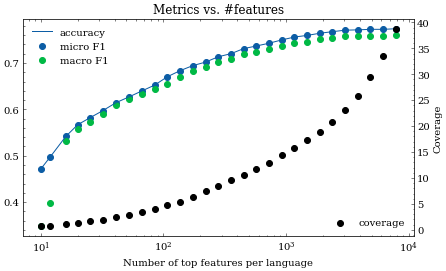

In [34]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.xlabel("Number of top features per language")

ax = plt.gca()
ax2 = plt.twinx()

ax2.scatter(rezdf.index, rezdf["coverage"], label="coverage", c="k")
ax2.set_ylabel("Coverage")
ax2.legend(loc="lower right")

plt.title("Metrics vs. #features")
plt.semilogx()
plt.savefig("images/20_in_domain_coverage_LinSVC.png")
plt.show()